# Analysis of dynamical polarizability of $CO$ in the linear response formalism

We analyze the computation of the dynamical polarizabilityi inside the linear response formalism.

The aim of this notebook is to:

* compute the Casida matrix associated to the highest value of virtual orbitals. 
* build the matrices associated to a lower number of virtual orbitals (by extracting its elements from the highest one) and discuss the rate of convergence of the statical polarizability to the reference value (formerly computed by including an explicit electric field). 
* evaluate the dynamical polarizability spectrum and discuss its stability in function of the number of virtual orbitals considered.  

In [1]:
%autosave 0
from BigDFT import Logfiles as lf
from BigDFT import Calculators as C
from futile import Yaml
import matplotlib.pyplot as plt
import numpy as np
import scipy.fftpack
import sys
sys.path.insert(0,'../')
import Routine as R
outputpath = 'linear-response/'

Autosave disabled


First of all we compute the coupling matrix

In [2]:
inp0 = {'dft' : 
        {'hgrids': 0.37,
         'gnrm_cv' : 1e-8,
         'itermax' : 100,
         'inputpsiid': 2},
        'tddft':{'tddft_approach': 'full'},
        'posinp': 'CO_posinp.xyz'}
Yaml.dump(inp0,outputpath + 'default.yaml')

In [2]:
virtMax = 282
rVal = 7.0

In [3]:
inp={'dft':
     {'rmult': [rVal, 9.0],
      'itermax_virt' : 1},
     'output': {
      'orbitals' : 'No',
      'verbosity' : 3}, 
     'radical': 'Rmult_7.0'}

inp['dft']['norbv'] = -virtMax
inpname = 'NumVirt_'+str(virtMax)
Yaml.dump(inp,outputpath + inpname + '.yaml')

We execute the input file and copy the coupling matrix and transition dipoles in the "TDDFT-Results" folder with the name coupling_matrix_n and transition_dipoles_n

In [4]:
code=C.SystemCalculator(omp=1,mpi=6)
%cd $outputpath
code.run(name='NumVirt_'+str(virtMax),skip=True,outdir='./log/')
%cd ../

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/CO/linear-response
Executing command:  mpirun -np 6 $BIGDFT_ROOT/bigdft -n NumVirt_282 -d ./log/ -s Yes
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/CO


Read the dipoles and coupling matrix

In [5]:
%cd $outputpath
dpath = 'log/TDDFT-Results/transition_dipoles_282.txt'
dipoles = np.loadtxt(dpath)
cpath = 'log/TDDFT-Results/coupling_matrix_282.txt'
C = np.loadtxt(cpath)
%cd ..

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/CO/linear-response
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/CO


We observe that $C$ is a symmetric matrix

In [6]:
np.allclose(C,C.T,atol=1.e-12)

True

### Analysis of the statical polarizability

We discuss the convergence of the static polarizability to its reference value obtained with the explicit electric field.
We make use of the "extract_subset" routine to build coupling matrix and dipoles corresponding to a given set of virtual orbitals.

In [7]:
alphaX = []
alphaY = []
alphaZ = []
virt = [16, 32, 48, 64, 80, 96, 112, 128, 160, 224, 256, virtMax]
for nind,nval in enumerate(virt):
    C_ext,dipoles_ext=R.extract_subset([5],[virtMax],C,dipoles,[nval])
    E2,C_E2=np.linalg.eigh(C_ext)
    sumx = 0.0
    sumy = 0.0
    sumz = 0.0
    for i,e in enumerate(E2):
        a = np.dot(C_E2.T[i],dipoles_ext)
        sumx+=2.0*a[0]*a[0]/e
        sumy+=2.0*a[1]*a[1]/e
        sumz+=2.0*a[2]*a[2]/e
    alphaX.append(sumx)
    alphaY.append(sumy)
    alphaZ.append(sumz)
print alphaX
print alphaY #to check if it equal to alphaX, ok!
print alphaZ

[9.5966645530540955, 11.355838900756071, 11.544540364021012, 11.919063395297401, 12.611191700260122, 12.628648206990395, 12.71703849364269, 12.717065118132892, 12.874311305584248, 13.070581476412981, 13.080665372818762, 13.113788887340034]
[9.5966645530540582, 11.355838900756074, 11.544540364020948, 11.919063395297369, 12.611191700260061, 12.628648206990359, 12.71703849364266, 12.717065118132846, 12.874311305584206, 13.070581476412945, 13.080665372818721, 13.113788883007453]
[12.875602242124209, 15.004124358518254, 16.259128284170647, 16.669204329083318, 16.955380307903688, 17.046156081643847, 17.366269886233702, 17.366302395770525, 17.714873175656784, 18.040745654207143, 18.070023873459771, 18.161401216784313]


In [8]:
alphaX_ref = 13.24
alphaZ_ref = 18.73

In [10]:
alphaX_norm = [i/alphaX_ref for i in alphaX]
alphaZ_norm = [i/alphaZ_ref for i in alphaZ]

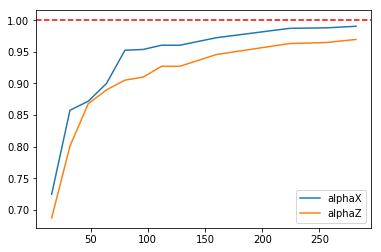

In [11]:
plt.plot(virt,alphaX_norm,label='alphaX')
plt.axhline(y=1.0, color='r', linestyle='--')
plt.plot(virt,alphaZ_norm,label='alphaZ')
plt.legend()
plt.show()

To check the correctness of the procedure for the construcion of the coupling matrix (given the one with the highest number of virtual orbitals) we compare some of the result obtained above with the ones build in terms of the true coupling matrix computed with 16 and 32 virtual orbitals.

In [12]:
%cd $outputpath
dpath = 'log/TDDFT-Results/transition_dipoles_16.txt'
dipoles_16 = np.loadtxt(dpath)
cpath = 'log/TDDFT-Results/coupling_matrix_16.txt'
C_16 = np.loadtxt(cpath)
dpath = 'log/TDDFT-Results/transition_dipoles_32.txt'
dipoles_32 = np.loadtxt(dpath)
cpath = 'log/TDDFT-Results/coupling_matrix_32.txt'
C_32 = np.loadtxt(cpath)
%cd ..

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/CO/linear-response
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/CO


In [13]:
alphaX_16 = 0.0
alphaZ_16 = 0.0
E2,C_E2=np.linalg.eigh(C_16)
for i,e in enumerate(E2):
    a = np.dot(C_E2.T[i],dipoles_16)
    alphaX_16+=2.0*a[0]*a[0]/e
    alphaZ_16+=2.0*a[2]*a[2]/e
print alphaX_16, alphaZ_16

alphaX_32 = 0.0
alphaZ_32 = 0.0
E2,C_E2=np.linalg.eigh(C_32)
for i,e in enumerate(E2):
    a = np.dot(C_E2.T[i],dipoles_32)
    alphaX_32+=2.0*a[0]*a[0]/e
    alphaZ_32+=2.0*a[2]*a[2]/e
print alphaX_32, alphaZ_32

9.59666455305 12.8756022421
11.3558389008 15.0041243585


Results agree with those obtained by the application of the "extract_subset" routine.

### Dynamical polarizability in the adiabatic case

We plot the imaginary part of (minus) $A(\omega_0)$ using the coupling matrix e transition dipoles in function of the number of virtual orbitals considered in the computation. In particular we want to compare results for numVirt = 64,128,virtMax

In [14]:
npoint = 1000
eta = 1.0e-2
omega = []
A = []
virt = [64,128,virtMax]
for ii,nVal in enumerate(virt):
    C_ext,dipoles_ext=R.extract_subset([5],[virtMax],C,dipoles,[nVal])
    E2,C_E2=np.linalg.eigh(C_ext)
    omegaMax = np.sqrt(E2[-1]) #square root of the highest eigenvalues
    print 'lenE2', len(E2), 'omegaMax', omegaMax
    omega.append(np.linspace(0.0,omegaMax,npoint))
    A_nVirt = np.zeros(npoint, dtype=complex)
    fE = []
    for i in range(len(E2)):
        fE.append(np.dot(C_E2.T[i],dipoles_ext[:,2]))
    for ind,o in enumerate(omega[ii]):
        s = 0.0
        for i,e in enumerate(E2):
            s+=fE[i]**2/(complex(o,2*eta)**2-e)
        A_nVirt[ind] = s
    A.append(-np.imag(A_nVirt))

lenE2 640 omegaMax 1.46081274276
lenE2 1280 omegaMax 1.66502703311
lenE2 2820 omegaMax 2.19043852007


In [15]:
omega_ev = []
for i in range(len(omega)):
    omega_ev.append(27.211*omega[i])

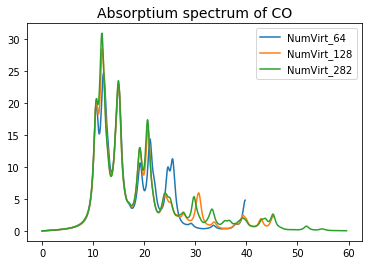

In [17]:
%matplotlib inline
#%matplotlib auto 
for i in range(len(virt)):
    plt.plot(omega_ev[i],A[i],label='NumVirt_'+str(virt[i]))
plt.legend()
plt.title('Absorptium spectrum of CO', fontsize=14)
plt.show()